## **Dependencies**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek # because our data is unbalanced

random_state = 42
np.random.seed(random_state)


## **Data Processing**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [3]:
dat_nurse = pd.read_csv('./prepared_641.csv')

In [ ]:
dat_nurse.head()

,HADM_ID,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,...,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,100571,1,100571,0.0,67,1,32.284350,1,0,0,...,656364,99008,2173-02-20,2173-02-20 06:44:00,2173-02-20 06:44:48,Nursing,Nursing Progress Note,18928.0,NaN,Hypotension (not Shock)\n Assessment:\n Hy...
1,100660,1,100660,0.0,75,1,NaN,1,0,0,...,1269150,631,2124-01-23,2124-01-23 14:03:00,2124-01-23 14:07:00,Nursing/other,Report,15597.0,NaN,Respiratory Care:\npt extubated to a 40% cool ...
2,100753,1,100753,0.0,52,2,21.788538,0,0,0,...,1270324,720,2160-05-04,2160-05-04 19:09:00,2160-05-04 19:22:00,Nursing/other,Report,15055.0,NaN,NSG ADMISSION NOTE\nMs. [**Name13 (STitle) 304...
3,100908,2,100908,0.0,89,1,28.646298,1,0,0,...,1621829,27504,2113-01-02,2113-01-02 06:31:00,2113-01-02 06:46:00,Nursing/other,Report,15746.0,NaN,ccu npn\n\n[**Age over 90 **] yr old male pmh:...
4,101197,1,101197,1.0,89,2,26.209730,0,1,0,...,1310787,3771,2190-12-12,2190-12-12 16:35:00,2190-12-12 16:37:00,Nursing/other,Report,20290.0,NaN,Respiratory Care Note\nPt received from PACU i...


In [ ]:
dat_nurse.info()

(array([548.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  92.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

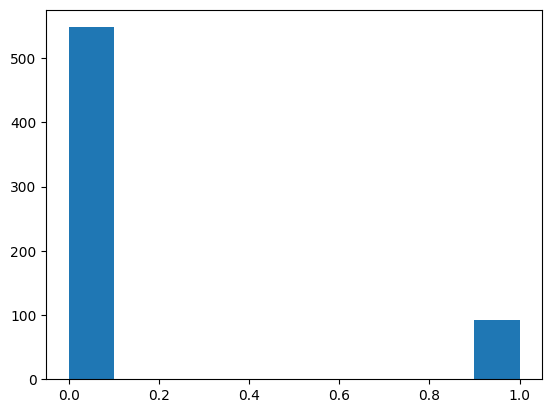

In [12]:
plt.hist(dat_nurse['outcome'])

In [4]:
# drop na (outcome na)
dat_nurse = dat_nurse[dat_nurse['outcome'].notnull()]
# train-test-split
train_dat, test_dat = train_test_split(dat_nurse, test_size = 0.15,  stratify=dat_nurse['outcome'], random_state=random_state)
# val_dat, test_dat = train_test_split(test_dat, test_size = 0.5, stratify=test_dat['outcome'], random_state=random_state)

In [5]:
# organizing data
clin_col = train_dat.columns[4:-10] # remove IDs, outcome, text
outcome_col = train_dat.columns[3]
text_col = train_dat.columns[-8:]

train_dat_clin, test_dat_clin = train_dat.loc[:, clin_col], test_dat.loc[:, clin_col]
train_dat_outcome, test_dat_outcome = train_dat.loc[:, outcome_col], test_dat.loc[:, outcome_col]
train_dat_text, test_dat_text = train_dat.loc[:, text_col], test_dat.loc[:, text_col]

In [ ]:
# standardize & impute clinical
# clin_pipe = Pipeline([
#     ('scalar', StandardScaler()),
#     ('med_imputer', SimpleImputer(strategy = "median"))
# ])

# clin_pipe.fit(train_dat_clin)
# train_dat_clin_imp = clin_pipe.transform(train_dat_clin)
# val_dat_clin_imp = clin_pipe.transform(val_dat_clin)
# test_dat_clin_imp = clin_pipe.transform(test_dat_clin)

## **TF-IDF**

In [10]:
# tfidf
train_doc = list(train_dat['TEXT'])
# val_doc = list(val_dat['TEXT'])
test_doc = list(test_dat['TEXT'])

tfidf_vectorizer = TfidfVectorizer(binary = True) # default l2 reg, 1-grams, binary word
tfidf_vectorizer.fit(train_doc)
train_dat_text_tfidf = tfidf_vectorizer.transform(train_doc).toarray()
# val_dat_text_tfidf = tfidf_vectorizer.transform(val_doc).toarray()
test_dat_text_tfidf = tfidf_vectorizer.transform(test_doc).toarray()

In [11]:
print(train_dat_text_tfidf.shape)

(544, 8842)


In [13]:
# combining data together
train_x = np.hstack([train_dat_text_tfidf])
# val_x = np.hstack([val_dat_text_tfidf])
test_x = np.hstack([test_dat_text_tfidf])

train_y = train_dat_outcome.to_numpy()
# val_y = val_dat_outcome.to_numpy()
test_y = test_dat_outcome.to_numpy()

# https://imbalanced-learn.org/stable/combine.html
print("train/val/test shape: ", train_x.shape, test_x.shape)#, val_x.shape, test_x.shape)

train/val/test shape:  (544, 8842) (96, 8842)


In [14]:
# SMOTE for imbalance
smote_tomek = SMOTETomek(random_state = random_state)
train_x_resamp, train_y_resamp = smote_tomek.fit_resample(train_x, train_y)
print(train_x[train_y == 0].shape, train_x[train_y == 1].shape)
print(train_x_resamp[train_y_resamp == 0].shape, train_x_resamp[train_y_resamp == 1].shape)

(466, 8842) (78, 8842)
(466, 8842) (466, 8842)


In [10]:
sum(train_x_resamp[0] != 0)

224

In [11]:
sum(train_x_resamp[0] == 0)

8618

In [55]:
train_y_resamp.shape

(932,)

## **Modelling**

In [6]:
params = {
    'LogisticRegressionCV' : {
        'penalty' : ['l2']
    },
    'SVC' : {
        'kernel' : ['linear', 'poly', 'rbf'],
        'degree' : [3, 4, 5]
    },
    'GaussianProcessClassifier' : { # https://stackoverflow.com/questions/62755556/gaussian-process-regression-hyparameter-optimisation-using-python-grid-search
            "kernel": [RBF(l) for l in np.logspace(-1, 1, 20)]
        },
    'XGBClassifier' : { # got from some towardsdatascience article i forgot
            'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'eval_metric': ['auc'],
            'objective': ['binary:logistic']
    }
}

In [7]:
def fit(x, y, parameters, n_iter, random_state = 42):
    """
    Randomized hyperparameter tuning for fitting models

    parameters:
        n_iter -- number of parameter settings sampled
    """
    print("Training LogisticRegressionCV:")
    lr = LogisticRegressionCV(max_iter = int(1e6))
    rs_lr = RandomizedSearchCV(lr, parameters['LogisticRegressionCV'], n_iter = n_iter, random_state=random_state)
    rs_lr.fit(x, y) 

    print("Training SVC:")
    svc = SVC(probability = True)
    rs_svc = RandomizedSearchCV(svc, parameters['SVC'], n_iter = n_iter, random_state=random_state)
    rs_svc.fit(x, y)

    print("Training GaussianProcessClassifier:")
    gp = GaussianProcessClassifier()
    rs_gp = RandomizedSearchCV(gp, parameters['GaussianProcessClassifier'], n_iter = n_iter, random_state=random_state)
    rs_gp.fit(x, y)

    print("Training XGBClassifier:")
    xgb = XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb, parameters['XGBClassifier'], n_iter = n_iter, random_state=random_state)
    rs_xgb.fit(x, y) 

    models = [rs_lr, rs_svc, rs_gp, rs_xgb]
    return models 


In [14]:
models = fit(train_x_resamp, train_y_resamp, params, n_iter = 20, random_state = random_state)

Training LogisticRegressionCV:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training SVC:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training GaussianProcessClassifier:
Training XGBClassifier:


In [15]:
for model in models:
    print(model.best_estimator_, model.best_params_, model.best_score_)

LogisticRegressionCV(max_iter=1000000) {'penalty': 'l2'} 0.9935598872980277
SVC(kernel='poly', probability=True) {'kernel': 'poly', 'degree': 3} 1.0
GaussianProcessClassifier(kernel=RBF(length_scale=0.1)) {'kernel': RBF(length_scale=0.1)} 0.9871427749985624
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, .

In [16]:
def evaluate(x, y, models):
    scores = {
        'ACC': [], 
        'AUC': [],
        'CMAT': []
    }
    for model in models:
        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:, 1]
        scores['ACC'].append(accuracy_score(y, y_pred))
        scores['AUC'].append(roc_auc_score(y, y_proba))
        scores['CMAT'].append(confusion_matrix(y, y_pred))
        
    return scores 

In [17]:
evaluate(test_x, test_y, models)

{'ACC': [0.84375, 0.8541666666666666, 0.8541666666666666, 0.84375],
 'AUC': [0.7020905923344947,
  0.7168989547038327,
  0.7134146341463414,
  0.6114982578397212],
 'CMAT': [array([[81,  1],
         [14,  0]]),
  array([[82,  0],
         [14,  0]]),
  array([[82,  0],
         [14,  0]]),
  array([[81,  1],
         [14,  0]])]}

## **word2vec (w/o )**

In [17]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [18]:
train_processed_text = train_dat['TEXT'].apply(simple_preprocess)

In [33]:
train_processed_text

230    [micu, admission, note, please, see, fhp, for,...
505    [title, this, is, age, over, year, old, with, ...
353    [resp, care, pt, received, from, ed, on, niv, ...
339    [admit, note, pt, presented, to, ed, with, dys...
612    [pt, remaines, on, points, restrainsd, agitati...
                             ...                        
123    [cva, with, right, sided, hemiparesisr, htn, a...
244    [micu, nursing, progress, note, briefly, this,...
161    [mrs, known, lastname, is, an, yo, woman, with...
168    [with, pmh, of, cad, distant, mi, cabg, chroni...
9      [sicu, nursing, admission, progress, note, mrs...
Name: TEXT, Length: 544, dtype: object

### Model with vector_size = 200:

In [35]:
word2vec_model = Word2Vec(sentences = train_processed_text, vector_size = 200, window = 5, min_count = 1)

In [36]:
def document_vector(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        if word in model.wv:
            doc_vector.append(model.wv[word])
            num_words += 1
    if num_words > 0:
        doc_vector = np.mean(doc_vector, axis=0)
    else:
        doc_vector = np.zeros(model.vector_size)
    return doc_vector

In [37]:
train_word2vec_repr = train_processed_text.apply(lambda x: document_vector(x, word2vec_model))

In [38]:
train_repr = np.vstack(train_word2vec_repr)

In [ ]:
word2vec_models = fit(train_repr, train_y, params, n_iter = 20, random_state = random_state)

In [69]:
for model in word2vec_models:
    print(model.best_estimator_, model.best_params_, model.best_score_)

LogisticRegressionCV(max_iter=1000000) {'penalty': 'l2'} 0.8566258919469929
SVC(kernel='linear', probability=True) {'kernel': 'linear', 'degree': 3} 0.8566258919469929
GaussianProcessClassifier(kernel=RBF(length_scale=0.1)) {'kernel': RBF(length_scale=0.1)} 0.8566258919469929
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, ra

In [65]:
test_processed_text = test_dat['TEXT'].apply(simple_preprocess)

In [66]:
test_word2vec_repr = test_processed_text.apply(lambda x: document_vector(x, word2vec_model))

In [67]:
test_repr = np.vstack(test_word2vec_repr)

In [73]:
evaluate(test_repr, test_y, word2vec_models)

{'ACC': [0.8541666666666666,
  0.8541666666666666,
  0.8541666666666666,
  0.8541666666666666],
 'AUC': [0.4878048780487805,
  0.6498257839721254,
  0.4891114982578397,
  0.4420731707317073],
 'CMAT': [array([[82,  0],
         [14,  0]]),
  array([[82,  0],
         [14,  0]]),
  array([[82,  0],
         [14,  0]]),
  array([[82,  0],
         [14,  0]])]}

## **word2vec (w/ Imbalance Treatment)**

In [46]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [60]:
under_sampling_strategy = 0.2
over_sampling_strategy = 1.0

resampling_pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy)),
    ('over', RandomOverSampler(sampling_strategy=over_sampling_strategy))
])

In [61]:
train_repr_resamp, train_y_resamp = resampling_pipeline.fit_resample(np.array(train_repr), np.array(train_y))

In [62]:
print(train_repr_resamp[train_y_resamp == 0].shape, train_repr_resamp[train_y_resamp == 1].shape)

(390, 200) (390, 200)


In [ ]:
word2vec_models_smote = fit(train_repr_resamp, train_y_resamp, params, n_iter = 30, random_state = random_state)

In [68]:
evaluate(test_repr, test_y, word2vec_models_smote)

{'ACC': [0.6666666666666666,
  0.5833333333333334,
  0.8541666666666666,
  0.8020833333333334],
 'AUC': [0.6428571428571428, 0.4930313588850174, 0.5, 0.5487804878048781],
 'CMAT': [array([[58, 24],
         [ 8,  6]]),
  array([[49, 33],
         [ 7,  7]]),
  array([[82,  0],
         [14,  0]]),
  array([[76,  6],
         [13,  1]])]}

### try penalization

In [74]:
from sklearn.metrics import make_scorer, confusion_matrix

def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Adjust the weight according to your preference
    false_negative_weight = 5
    
    score = tp - false_negative_weight * fn
    return score
  
custom_scorer = make_scorer(custom_scorer, greater_is_better=True)

In [75]:
def fit_penalized(x, y, parameters, n_iter, random_state = 42):
    print("Training GaussianProcessClassifier:")
    gp = GaussianProcessClassifier()
    rs_gp = RandomizedSearchCV(gp, parameters['GaussianProcessClassifier'], n_iter = n_iter, random_state=random_state, scoring=custom_scorer)
    rs_gp.fit(x, y)

    print("Training XGBClassifier:")
    xgb = XGBClassifier()
    parameters['XGBClassifier']['scale_pos_weight'] = [5] 
    rs_xgb = RandomizedSearchCV(xgb, parameters['XGBClassifier'], n_iter = n_iter, random_state=random_state)
    rs_xgb.fit(x, y) 

    models = [rs_gp, rs_xgb]
    return models 

In [ ]:
word2vec_models_smote = fit_penalized(train_repr_resamp, train_y_resamp, params, n_iter = 30, random_state = random_state)

In [78]:
evaluate(test_repr, test_y, word2vec_models_smote)

{'ACC': [0.8541666666666666, 0.8020833333333334],
 'AUC': [0.5, 0.6202090592334495],
 'CMAT': [array([[82,  0],
         [14,  0]]),
  array([[75,  7],
         [12,  2]])]}